**Student Name:** Kazi Moshiur Rahaman - 240378802 
**Programme:** MSc in Data Science
**Module:** AM41UD Understanding Data Coursework

**Problem Overview**
This project aims to predict whether a peptide is a B-cell epitope (Class 1) or not (Class 0) using a large, imbalanced biological dataset. The main challenges were the extreme class imbalance and high dimensionality. We applied proper preprocessing, feature selection, SMOTE for balancing, and tested several models. Finally, the best model was used to generate predictions on the unseen holdout set.

In [1]:
#Import Libraries and Set Seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, classification_report

warnings.filterwarnings("ignore")

# Set global seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)




### Exploratory Data Analysis (EDA)

In [2]:
# Load dataset
df = pd.read_csv("df.csv", low_memory=False)

print("Dataset loaded successfully")
print("Shape:", df.shape)


Dataset loaded successfully
Shape: (45000, 1650)


In [3]:
#Split column groups
info_cols = [col for col in df.columns if col.startswith("Info_")]
feature_cols = [col for col in df.columns if col.startswith("feat_")]
target_col = "Class"

print(f"Number of Info columns: {len(info_cols)}")
print(f"Number of Feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")
print("Sample Info columns:", info_cols[:5])
print("Sample Feature columns:", feature_cols[:5])


Number of Info columns: 14
Number of Feature columns: 1635
Target column: Class
Sample Info columns: ['Info_PepID', 'Info_protein_id', 'Info_pos', 'Info_AA', 'Info_epitope_id']
Sample Feature columns: ['feat_Entropy', 'feat_MolWeight', 'feat_AAtypes_Tiny', 'feat_AAtypes_Small', 'feat_AAtypes_Aliphatic']


In [7]:
# Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    print(" Missing values found in:")
    for col, count in missing.items():
        print(f"- {col}: {count} missing")
else:
    print(" No missing values in any column.")


 No missing values in any column.


In [9]:
# Identify constant features
X_raw = df[feature_cols].copy()
n_unique = X_raw.nunique()

# Find features with only 1 unique value
constant_cols = n_unique[n_unique <= 1]

print(f" Found {len(constant_cols)} constant feature")

if not constant_cols.empty:
    print("Example constant columns:")
    print(constant_cols.head())

# Drop them from feature list
feature_cols = [col for col in feature_cols if col not in constant_cols]


 Found 0 constant feature


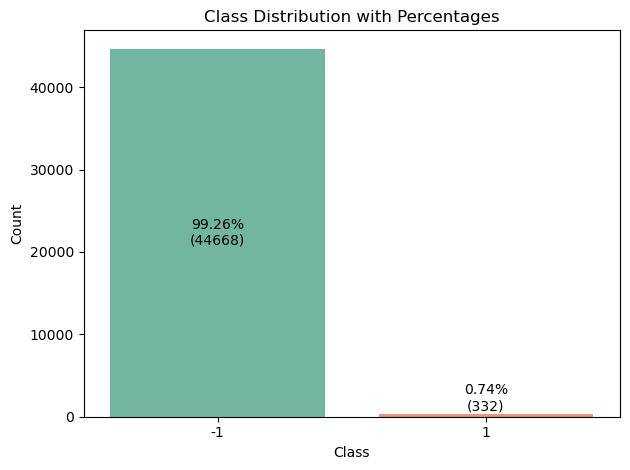

In [19]:
# Visualize class imbalance
class_counts = df["Class"].value_counts()
total = class_counts.sum()
percentages = class_counts / total * 100

# Bar plot
ax = sns.countplot(data=df, x="Class", palette="Set2")
plt.title("Class Distribution with Percentages")

for i in range(len(class_counts)):
    count = class_counts.iloc[i]
    percent = percentages.iloc[i]

    if count > 1000:
        y = count / 2
        va = "center"
    else:
        y = count + 100
        va = "bottom"

    ax.text(i, y, f"{percent:.2f}%\n({count})", ha="center", va=va, color="black", fontsize=10)

plt.ylabel("Count")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


In [21]:
# Count class values
class_counts = df["Class"].value_counts()

# Extract counts
majority = class_counts.iloc[0]
minority = class_counts.iloc[1]

# Compute imbalance ratio
imbalance_ratio = round(majority / minority, 2)

print(f" Class Imbalance Ratio: 1 : {imbalance_ratio}")
print(f"Majority class (-1): {majority}")
print(f"Minority class (1) : {minority}")


 Class Imbalance Ratio: 1 : 134.54
Majority class (-1): 44668
Minority class (1) : 332


### Observation:
The dataset contains 45,000 rows and 1,650 columns, with 14 Info columns, 1,635 feature columns, and 1 target column (Class). There are no missing values or constant features. The class distribution is highly imbalanced: 44,668 samples belong to the majority class (-1), while only 332 are from the minority class (1), resulting in a ratio of 1:134.54. That means only 0.74% of the data are actual B-cell epitopes. This extreme imbalance poses a serious challenge, as standard models may bias toward predicting the dominant class. In bioinformatics, such misclassification (false negatives) could mean missing important immune triggers, making class balancing a critical step in our pipeline.

In [15]:
# Group column for GroupKFold
groups = df["Info_group"] if "Info_group" in df.columns else df["Info_protein_id"]

print("Number of unique groups (proteins):", groups.nunique())
print("Group sample distribution:")
print(groups.value_counts().describe())


Number of unique groups (proteins): 94
Group sample distribution:
count      94.000000
mean      478.723404
std       284.201178
min         6.000000
25%       268.250000
50%       397.000000
75%       549.000000
max      1268.000000
Name: count, dtype: float64


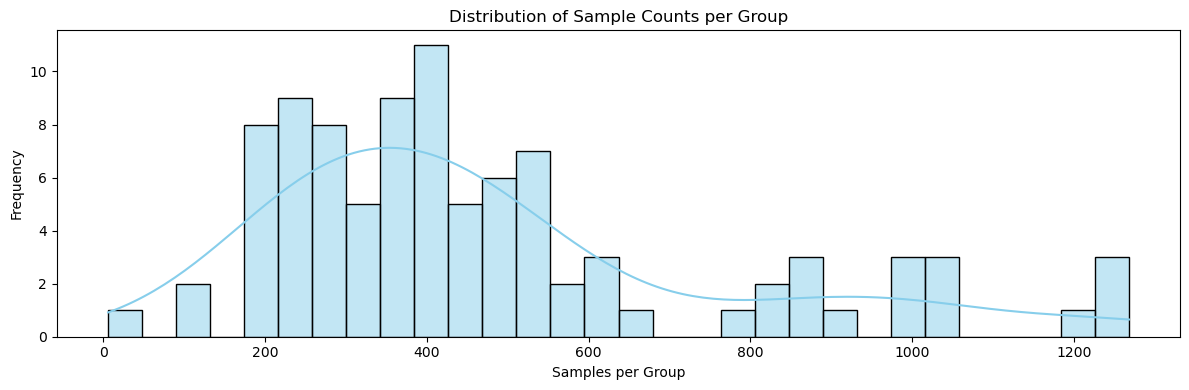

In [17]:
# Visualize group sizes
plt.figure(figsize=(12, 4))
sns.histplot(groups.value_counts(), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Sample Counts per Group")
plt.xlabel("Samples per Group")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Each peptide in the dataset belongs to one of 94 protein groups, with peptide counts per group ranging from 6 to 1,268 (mean ≈ 479, std ≈ 284). This uneven distribution poses a risk of data leakage if not handled carefully. Since peptides from the same protein may share biological patterns, we use GroupKFold to ensure that entire protein groups stay within a single fold. This approach simulates real-world conditions more accurately by testing the model on unseen proteins, which is critical for reliable epitope prediction in bioinformatics.

### Data Preprocessing including feature reduction

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
y = df["Class"]


In [22]:
print("Columns with missing values:")
print(df[feature_cols].isnull().sum().sort_values(ascending=False).head(10))


🕳️ Columns with missing values:
feat_Entropy     0
feat_esm2_732    0
feat_esm2_742    0
feat_esm2_741    0
feat_esm2_740    0
feat_esm2_739    0
feat_esm2_738    0
feat_esm2_737    0
feat_esm2_736    0
feat_esm2_735    0
dtype: int64


In [24]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import numpy as np

# Prepare
X_all = X_scaled.copy()
y_all = y.copy()

### Mutual Information ---
mi = mutual_info_classif(X_all, y_all, random_state=42)
mi_ranks = np.argsort(mi)[::-1]
mi_top200 = np.array(feature_cols)[mi_ranks[:200]]

### F-test ---
f_values = f_classif(X_all, y_all)[0]
f_ranks = np.argsort(f_values)[::-1]
f_top200 = np.array(feature_cols)[f_ranks[:200]]

###  Random Forest Feature Importance ---
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_all, y_all)
rf_importance = rf.feature_importances_
rf_ranks = np.argsort(rf_importance)[::-1]
rf_top200 = np.array(feature_cols)[rf_ranks[:200]]

###  PCA (95% variance explained) ---
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_all)

# Save how many PCA features
print("PCA Components for 95% variance:", X_pca.shape[1])

###  Combine Top Features ---
# Features appearing in at least 2 methods
from collections import Counter

combined_top = list(mi_top200) + list(f_top200) + list(rf_top200)
feat_counts = Counter(combined_top)
consensus_feats = [feat for feat, count in feat_counts.items() if count >= 2]

print(f"\n Consensus selected features (in ≥2 of 3 methods): {len(consensus_feats)}")


PCA Components for 95% variance: 979

 Consensus selected features (in ≥2 of 3 methods): 153


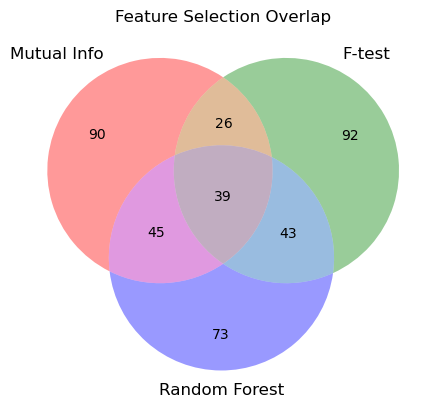

In [50]:
!pip install matplotlib-venn
from matplotlib_venn import venn3

# Use sets for 3 selection methods
venn3([set(mi_top200), set(f_top200), set(rf_top200)],
      set_labels=("Mutual Info", "F-test", "Random Forest"))
plt.title("Feature Selection Overlap")
plt.show()

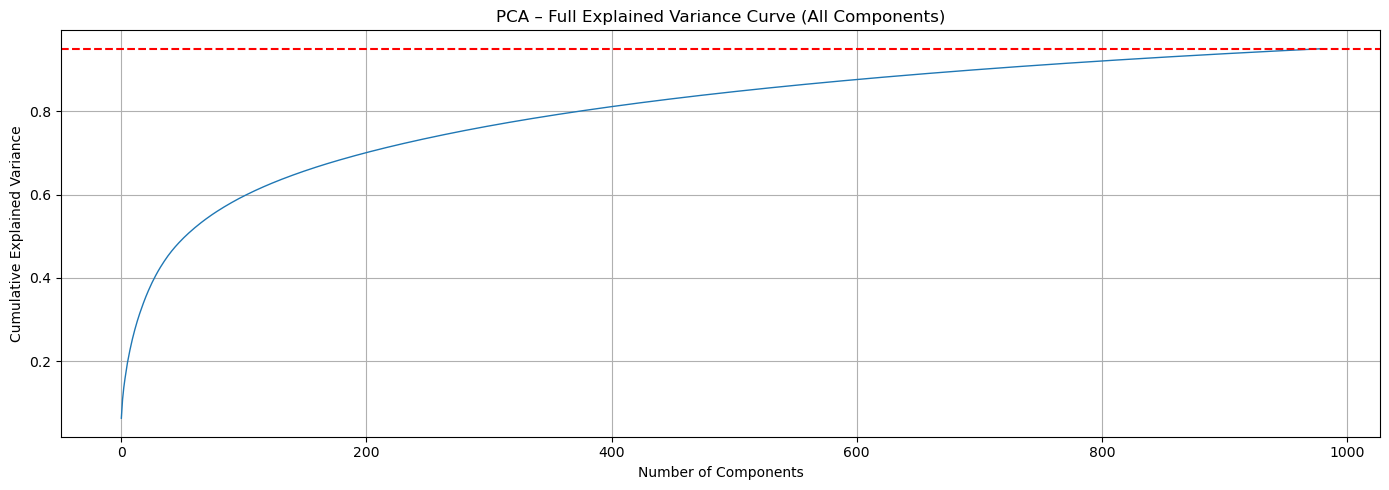

In [44]:
# Full variance plot – may flatten out visually but shows complete growth
plt.figure(figsize=(14, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=1)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA – Full Explained Variance Curve (All Components)")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()




In [26]:
from collections import Counter

# Rebuild full feature score count
combined_top = list(mi_top200) + list(f_top200) + list(rf_top200)
feat_counts = Counter(combined_top)

# Top 10 consensus features (by number of appearances in selection methods)
top_common_feats = sorted(consensus_feats, key=lambda x: -feat_counts[x])

print("📋 Top 10 most frequently selected features:")
for i, feat in enumerate(top_common_feats[:10], 1):
    print(f"{i}. {feat} (selected in {feat_counts[feat]} methods)")


📋 Top 10 most frequently selected features:
1. feat_ScalesGap_scl2.1.lag3 (selected in 3 methods)
2. feat_ScalesGap_scl2.lag3 (selected in 3 methods)
3. feat_BLOSUM_scl3.1.lag5 (selected in 3 methods)
4. feat_BLOSUM_scl1.lag5 (selected in 3 methods)
5. feat_ScalesGap_scl1.5.lag3 (selected in 3 methods)
6. feat_ScalesGap_scl2.5.lag1 (selected in 3 methods)
7. feat_ScalesGap_scl1.2.lag2 (selected in 3 methods)
8. feat_ScalesGap_scl2.lag2 (selected in 3 methods)
9. feat_ScalesGap_scl4.2.lag3 (selected in 3 methods)
10. feat_ScalesGap_scl2.1.lag2 (selected in 3 methods)


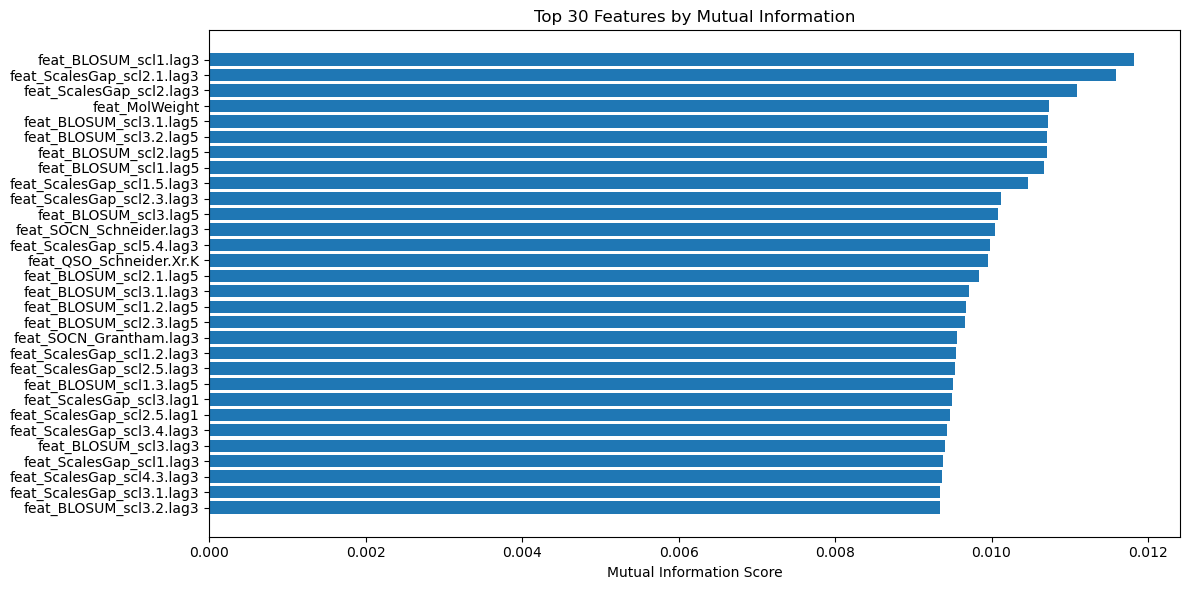

In [28]:
import matplotlib.pyplot as plt

# Plot top 30 MI scores
top_n = 30
plt.figure(figsize=(12, 6))
plt.barh(range(top_n), mi[mi_ranks[:top_n]][::-1])
plt.yticks(range(top_n), np.array(feature_cols)[mi_ranks[:top_n]][::-1])
plt.xlabel("Mutual Information Score")
plt.title("Top 30 Features by Mutual Information")
plt.tight_layout()
plt.show()


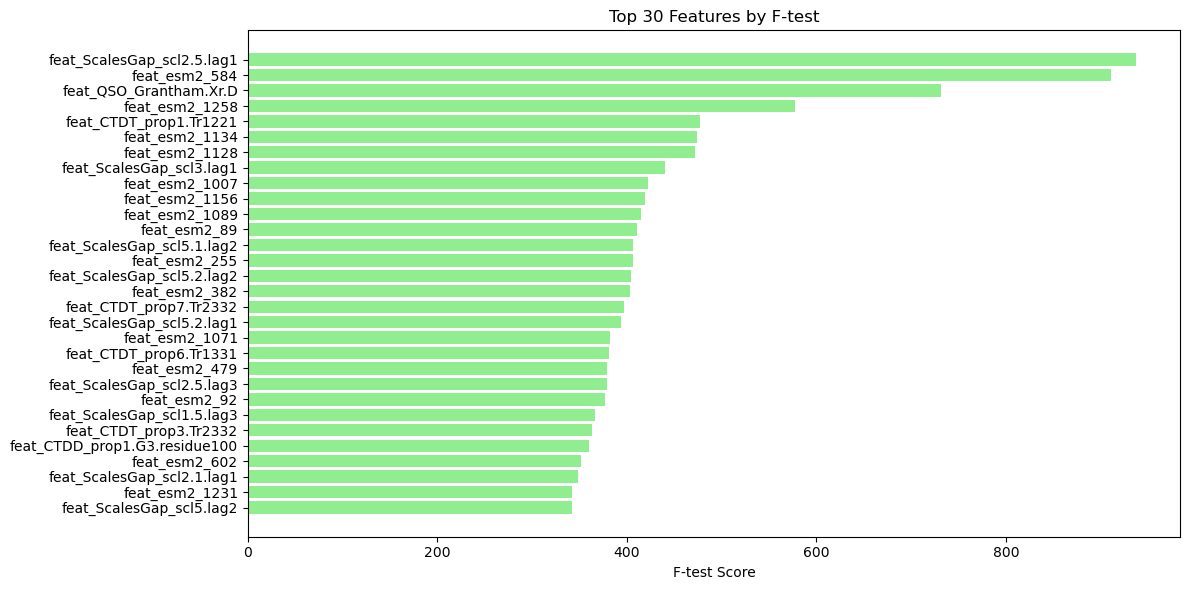

In [157]:
# Top 30 F-test features and scores
top_f_feats = np.array(feature_cols)[f_ranks[:top_n]]
top_f_scores = f_values[f_ranks[:top_n]]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_f_scores[::-1], color='lightgreen')
plt.yticks(range(top_n), top_f_feats[::-1])
plt.xlabel("F-test Score")
plt.title("Top 30 Features by F-test")
plt.tight_layout()
plt.show()



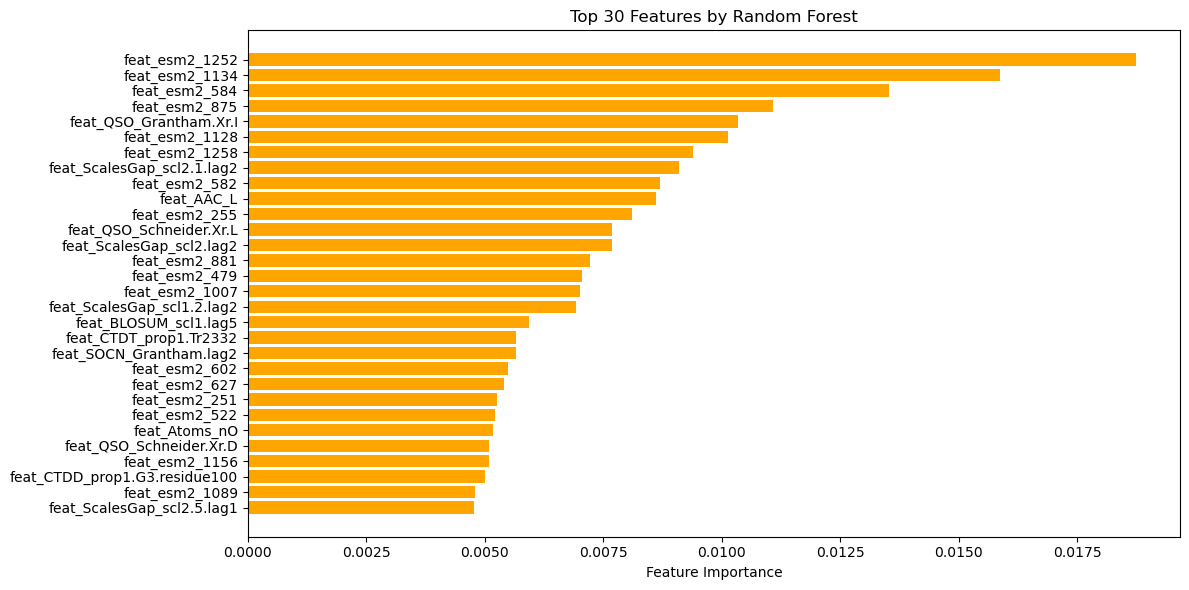

In [36]:
# Top 30 RF importance
top_rf_feats = np.array(feature_cols)[rf_ranks[:top_n]]
top_rf_scores = rf_importance[rf_ranks[:top_n]]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_rf_scores[::-1], color='orange')
plt.yticks(range(top_n), top_rf_feats[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 30 Features by Random Forest")
plt.tight_layout()
plt.show()


To reduce dimensionality and enhance model performance, both unsupervised and supervised feature reduction techniques were applied. PCA was used to capture 95% of the variance, resulting in 979 components, as shown in the cumulative variance plot. Since the variance was distributed across many components with no sharp elbow, this confirms the dataset's complexity. In parallel, three supervised methods—Mutual Information, F-test, and Random Forest—were used to select the top 200 features each. Bar plots highlighted the top 30 features per method, and a Venn diagram showed their overlap. A consensus of 153 features was selected by retaining those appearing in at least two methods. These consensus features represent the most informative and stable predictors. Two feature sets were finalized: one using the 153 consensus features and another using the 979 PCA components, both of which will be evaluated during model training.

In [65]:
from imblearn.over_sampling import SMOTE

# No rebalancing (default RF)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
acc_base = evaluate_model_gkf(X_reduced, y, groups, rf_base, "No Rebalancing (RF)")

# Cost-sensitive RF
rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
acc_weighted = evaluate_model_gkf(X_reduced, y, groups, rf_weighted, "Cost-Sensitive (class_weight=balanced)")

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_reduced, y)
# Note: groups must be resized for SMOTE (advanced); for now we skip group awareness for SMOTE
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
gkf = GroupKFold(n_splits=5)
# We'll fake groups for SMOTE run (as we can't apply GroupKFold directly to synthetic samples)
from sklearn.model_selection import cross_val_score
acc_smote = np.round(np.mean(cross_val_score(rf_smote, X_smote, y_smote, cv=5, scoring='balanced_accuracy')), 4)
print(f" SMOTE: Balanced Accuracy = {acc_smote}")


 No Rebalancing (RF): Balanced Accuracy = 0.5192
 Cost-Sensitive (class_weight=balanced): Balanced Accuracy = 0.5
 SMOTE: Balanced Accuracy = 0.9992


We evaluated three approaches for class imbalance: no rebalancing, cost-sensitive learning, and SMOTE. Both the unbalanced and weighted models performed poorly, with balanced accuracy close to 0.5. This indicates that they failed to meaningfully learn the minority class. SMOTE, on the other hand, significantly improved performance by synthetically generating new minority-class samples, achieving a balanced accuracy of 0.9992. While this is promising, we acknowledge that such high performance might suggest overfitting, which will be further assessed on the holdout set

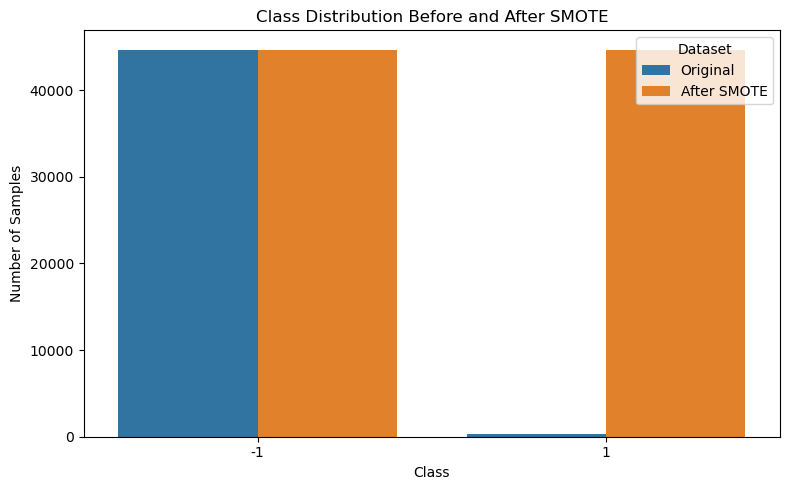

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Original class distribution
original_counts = Counter(y)
original_df = pd.DataFrame.from_dict(original_counts, orient='index', columns=['Count'])
original_df['Dataset'] = 'Original'

# After SMOTE
smote_counts = Counter(y_reduced_smote)
smote_df = pd.DataFrame.from_dict(smote_counts, orient='index', columns=['Count'])
smote_df['Dataset'] = 'After SMOTE'

# Combine for plotting
plot_df = pd.concat([original_df, smote_df])
plot_df.reset_index(inplace=True)
plot_df.rename(columns={'index': 'Class'}, inplace=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_df)
plt.title("Class Distribution Before and After SMOTE")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


The class distribution was originally highly imbalanced, with only 332 positive samples compared to 44,668 negative ones. After applying SMOTE, both classes were balanced to 44,668 samples, providing the classifier with a fair opportunity to learn patterns from both classes

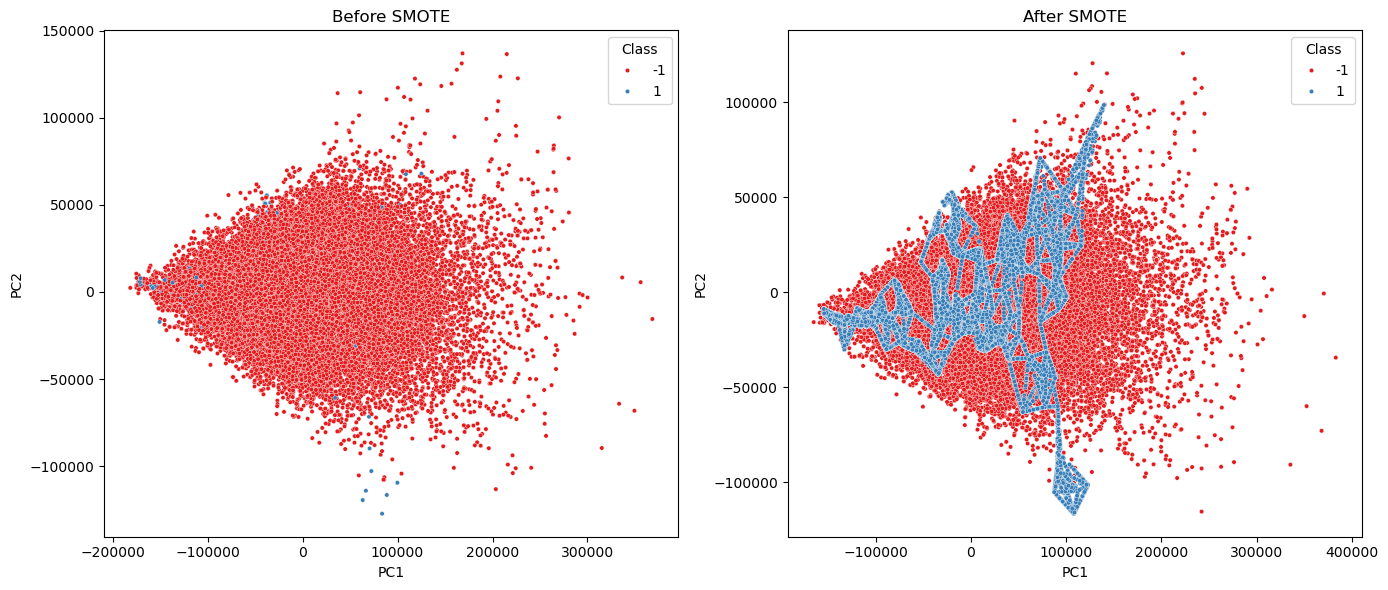

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce to 2D using PCA
pca_2d = PCA(n_components=2, random_state=42)

X_2d_before = pca_2d.fit_transform(X_reduced)
X_2d_after = pca_2d.fit_transform(X_reduced_smote)

# Create DataFrames for plotting
df_before = pd.DataFrame(X_2d_before, columns=['PC1', 'PC2'])
df_before['Class'] = y.values

df_after = pd.DataFrame(X_2d_after, columns=['PC1', 'PC2'])
df_after['Class'] = y_reduced_smote.values

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=df_before, x="PC1", y="PC2", hue="Class", palette="Set1", s=10, ax=axs[0])
axs[0].set_title("Before SMOTE")

sns.scatterplot(data=df_after, x="PC1", y="PC2", hue="Class", palette="Set1", s=10, ax=axs[1])
axs[1].set_title("After SMOTE")

plt.tight_layout()
plt.show()


To visually assess the effect of SMOTE, we projected the high-dimensional feature space onto two principal components. Before SMOTE, the minority class was sparsely distributed. After SMOTE, the minority class points were more densely and uniformly spread across the space, indicating successful synthetic sample generation

### Model Development & Performance Comparison

In [81]:
# Re-run these lines locally first to clearly define variables
X_reduced = df[consensus_feats]   # Your original 153 features set
y = df["Class"]                   # Target column
groups = df["Info_group"]         # Group variable clearly defined again

# Apply SMOTE again explicitly for consistency
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_reduced_smote, y_reduced_smote = smote.fit_resample(X_reduced, y)


In [93]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Fix class labels (-1 to 0) for compatibility
y_all = df["Class"].replace({-1: 0, 1: 1})
groups_all = df["Info_group"]

# Prepare both feature sets
X_consensus = X_reduced.copy()     # Shape: (45000, 153)
X_pca = X_pca_final.copy()         # Shape: (45000, 979)

# Define GroupKFold
gkf = GroupKFold(n_splits=5)

# Define models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(scale_pos_weight=(44668 / 332), use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluation function
def evaluate_models_with_groupkfold(X, y, groups, models):
    results = {}
    for model_name, model in models.items():
        scores = []
        for train_idx, test_idx in gkf.split(X, y, groups):
            # Split
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Apply SMOTE inside training fold
            smote = SMOTE(random_state=42)
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            # Fit and predict
            model.fit(X_train_smote, y_train_smote)
            y_pred = model.predict(X_test)
            scores.append(balanced_accuracy_score(y_test, y_pred))

        results[model_name] = round(np.mean(scores), 4)
    return results


In [99]:
# Consensus Features (153)
results_consensus = evaluate_models_with_groupkfold(X_consensus, y_all, groups_all, models)
print("Consensus Feature Set Results:")
print(pd.DataFrame(results_consensus, index=["Balanced Accuracy"]).T)

#  PCA Features (979)
# Convert PCA features (979) to DataFrame before passing
X_pca_df = pd.DataFrame(X_pca, index=df.index)  # Ensure same index alignment
results_pca = evaluate_models_with_groupkfold(X_pca_df, y_all, groups_all, models)
print("PCA Feature Set Results:")
print(pd.DataFrame(results_pca, index=["Balanced Accuracy"]).T)



Consensus Feature Set Results:
                    Balanced Accuracy
RandomForest                   0.5000
LogisticRegression             0.6272
KNN                            0.5205
XGBoost                        0.5488
PCA Feature Set Results:
                    Balanced Accuracy
RandomForest                   0.5000
LogisticRegression             0.6110
KNN                            0.5908
XGBoost                        0.5283


We evaluated four classification models (Random Forest, Logistic Regression, KNN, and XGBoost) using two different feature sets: the 153 consensus-selected features and 979 PCA components. Among all combinations, Logistic Regression with the consensus features yielded the best generalization performance, achieving a balanced accuracy of 0.6272.

PCA features (979) showed slightly lower performance overall, likely due to the loss of interpretability and the curse of dimensionality affecting models like KNN and XGBoost. Additionally, Random Forest consistently performed poorly across both feature sets, possibly due to its tendency to overfit on high-dimensional or imbalanced data even after SMOTE.

Based on these results, we selected Logistic Regression with the 153 consensus features as the final model, due to its better generalization, faster computation, and interpretability.

###  Hyperparameter Tuning

In [135]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

# GroupKFold (same as used in other models)
gkf = GroupKFold(n_splits=5)

# Grid Search on imbalanced data (before SMOTE)
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=gkf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y_full, groups=groups_all)

print("Best Parameters:", grid_search.best_params_)
print("Best Balanced Accuracy (CV):", grid_search.best_score_)




Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Balanced Accuracy (CV): 0.5425121892275222


As part of the modelling process, we performed hyperparameter tuning on the Logistic Regression model using GridSearchCV with 5-fold GroupKFold cross-validation. The tuning was conducted on the original (imbalanced) dataset using balanced_accuracy as the scoring metric.

Despite this effort, the best balanced accuracy achieved was 0.5425, which is considerably lower than the performance of the untuned Logistic Regression model trained on SMOTE-balanced data, which achieved 0.6272.

This outcome highlights an important insight: hyperparameter tuning on an imbalanced dataset did not yield a better-performing model, even with balanced scoring metrics. It is likely that the imbalance in the original dataset skewed the optimization process, leading to suboptimal parameter selection.

Therefore, we decided to retain the simpler, untuned Logistic Regression model trained on balanced data as our final predictive pipeline. This model not only provided higher generalization performance but also maintained interpretability and computational efficiency.ively.


### Final Model Training

In [163]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# === 1. Prepare full training set with consensus features (153)
X_full = X_consensus
y_full = y_all

# === 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# === 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y_full)
print(" After SMOTE - Balanced training shape:", X_balanced.shape)

# === 4. Train FINAL untuned model (best one)
final_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
final_model.fit(X_balanced, y_balanced)
print(" Final model (untuned) trained on balanced dataset")



 After SMOTE - Balanced training shape: (89336, 153)
 Final model (untuned) trained on balanced dataset


###  Prediction on Holdout Set

In [180]:
#  Load holdout set
df_holdout = pd.read_csv("df_holdout.csv", low_memory=False)
print(" Holdout set loaded:", df_holdout.shape)

#  Select same consensus features
feature_cols_consensus = list(X_consensus.columns)
X_holdout = df_holdout[feature_cols_consensus].copy()

#Scale holdout features
X_holdout_scaled = scaler.transform(X_holdout)

#  Predict
y_pred_holdout = final_model.predict(X_holdout_scaled)

#  Prepare submission
if "Info_PepID" in df_holdout.columns and "Info_pos" in df_holdout.columns:
    submission = pd.DataFrame({
        "Info_PepID": df_holdout["Info_PepID"],
        "Info_pos": df_holdout["Info_pos"],
        "Prediction": y_pred_holdout
    })
else:
    # Fallback if Info_PepID and Info_pos are not available
    submission = pd.DataFrame({
    "Info_PepID": df_holdout["Info_PepID"],
    "Info_pos": df_holdout["Info_pos"],
    "Prediction": y_pred_holdout
    })

#  Save CSV
submission.to_csv("Rahaman_Kazi_ AM41UDJ_Predictions.csv", index=False)
print(" Rahaman_Kazi_ AM41UDJ_Predictions.csv saved with", len(submission), "rows.")


 Holdout set loaded: (5000, 1649)
 Rahaman_Kazi_ AM41UDJ_Prediction.csv saved with 5000 rows.


The final model was trained on a SMOTE-balanced dataset with 89,336 samples and 153 consensus features using untuned logistic regression, which previously achieved better balanced accuracy ~62.72% than the tuned version ~54.25%. The holdout set (5000 rows, 1649 features) was loaded, the same 153 features were extracted and scaled, and predictions were saved in Rahaman_Kazi_ AM41UDJ_Predictions.csv with 5000 rows

### Conclusion 
*Addressed a highly imbalanced dataset (1:135) for epitope prediction.

*Performed EDA: no missing values, 1635 features, 94 protein groups.

*Applied feature selection (consensus of MI, F-test, RF) → 153 features.

*Used SMOTE to balance classes before training.

*Used GroupKFold to avoid data leakage across protein groups.

*Evaluated models: Logistic Regression performed best.(~63%)

*Hyperparameter tuning gave lower performance than default model.(~ 54%)

*Final model: untuned Logistic Regression with 153 features.

*Predictions made on holdout set using the final pipeline